<a href="https://colab.research.google.com/github/surkovvv/loan_default_prediction/blob/misha/11_12_%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22LoanDefaultPrediction_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузим все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [2]:
X = pd.read_csv("applicationdata.csv")
X.sample(5)

,CustomerID,LoanType,Reason,Application.Date,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,Residential.Status,Sex,Marital.Status,Dependents,City,State,PostalCode,Pay.Frequency,Product,Risk.Rating,Employment.Type,Requested.Duration,ArrearsLevel,IsWrittenOff,age.of.file,age.of.subject,time.at.address,time.at.employer,defaults,total.value.of.outstanding.defaults,defaults.paid,defaults.12,time.since.last.default,credit.enquiries.1,credit.enquiries.3,credit.enquiries.6,credit.enquiries.12,credit.enquiries.60,...,OverdrawnFees_wages_ratio,UncategorisedDebits_wages_ratio,OtherDebits_wages_ratio,AllOtherCredits_wages_ratio,Utilities_wages_ratio,AtmWithdrawals_wages_ratio,Gambling_wages_ratio,Groceries_wages_ratio,Insurance_wages_ratio,SubscriptionTv_wages_ratio,Telecommunications_wages_ratio,Transport_wages_ratio,Wages_repaymentcapacity_ratio,Centrelink_repaymentcapacity_ratio,SaccLoans_repaymentcapacity_ratio,NonSaccLoans_repaymentcapacity_ratio,DebtConsolidation_repaymentcapacity_ratio,DebtCollection_repaymentcapacity_ratio,Rent1_repaymentcapacity_ratio,OverdrawnFees_repaymentcapacity_ratio,UncategorisedDebits_repaymentcapacity_ratio,OtherDebits_repaymentcapacity_ratio,AllOtherCredits_repaymentcapacity_ratio,Utilities_repaymentcapacity_ratio,AtmWithdrawals_repaymentcapacity_ratio,Gambling_repaymentcapacity_ratio,Groceries_repaymentcapacity_ratio,Insurance_repaymentcapacity_ratio,SubscriptionTv_repaymentcapacity_ratio,Telecommunications_repaymentcapacity_ratio,Transport_repaymentcapacity_ratio,Income_MonthlyRepayments_ratio,NonDiscretionarySpending_MonthlyRepayments_ratio,DiscretionarySpending_MonthlyRepayments_ratio,RepaymentCapacity_MonthlyRepayments_ratio,MaxCdia,Isdefault,Isapproved,Inrange,Hasjson
5457,239805.0,New,Maintenance & accessories,2017-05-27 21:34:27.317,3 months to 1 year,Retail,3500.0,3500.0,3500.0,18 months,21.0,gmail.com,Living with friends,M,Single,0,Bungarribee,New South Wales,2767.0,Weekly,MACC,A5,Full time,24 months,M1,0.0,20.00,21.00,12.0,2.0,0.0,0.0,0.0,0.0,NaN,2.0,3.0,3.0,7.0,10.0,...,0.0000,0.0271,0.0497,1.7412,0.0,0.2973,0.7175,0.0078,0.0,0.0,0.0512,0.0275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.5081,4.0379,28.0986,-6.6284,20.0,0.0,1.0,1.0,1.0
7461,258347.0,New,Maintenance & accessories,2017-08-05 10:39:33.400,3 months to 1 year,Other,8000.0,5100.0,5100.0,24 months,39.0,email.com,Rent,F,Defacto,1,Mataranka,Northern Territory,852.0,Fortnightly,PL,A5,Part time,36 months,M1,0.0,158.91,474.76,0.0,0.0,0.0,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,3.0,...,0.0019,0.2458,0.2458,0.1499,0.0,0.2560,0.0000,0.0000,0.0,0.0,0.0000,0.0000,2.3601,1.5488,0.0000,0.0,0.0,0.0,0.0641,0.0052,0.6708,0.6708,0.4092,0.0,0.6986,0.0000,0.0000,0.0,0.0,0.0000,0.0000,5.4770,2.0670,1.4025,2.0074,52.0,0.0,1.0,1.0,1.0
9418,154564.0,Repeat,Purchase,2017-08-22 16:06:04.333,3 months to 1 year,"Construction, Building & Architecture",3000.0,3000.0,3000.0,24 months,19.0,gmail.com,Living with friends,M,Single,0,Bradbury,New South Wales,2560.0,Weekly,MACC,A5,Part time,24 months,M0,0.0,0.00,18.00,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0071,0.0071,1.4837,0.0,0.0038,0.0906,0.0102,0.0,0.0,0.0009,0.0122,1.2892,0.0087,0.1053,0.0,0.0,0.0,0.0000,0.0000,0.0092,0.0092,1.9258,0.0,0.0049,0.1176,0.0132,0.0,0.0,0.0011,0.0159,13.6596,1.1084,2.0275,10.5236,3.0,0.0,1.0,1.0,1.0
2200,205832.0,New,Rent or rental bond,2017-02-07 01:36:26.907,More than 1 year,"Logistics, Transport & Supply",3100.0,3100.0,3100.0,18 months,44.0,hotmail.com,Rent,M,Married,3+,Lakemba,New South Wales,2195.0,Weekly,MACC,A4,Full time,18 months,M0,0.0,173.00,44.00,152.0,11.0,0.0,0.0,0.0,0.0,NaN,1.0,2.0,2.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,6.3919,1.7934,-8.1853,0.0,0.0,1.0,1.0,1.0
6909,246377.0,New,"Transport or petrol,Household bills (e.g. elec...",2017-06-20 09:17:33.293,More th

# Отступ ⬇

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12982 entries, 0 to 12981
Columns: 216 entries, CustomerID to Hasjson
dtypes: float64(194), object(22)
memory usage: 21.4+ MB


In [4]:
features = X.columns.values
features.shape[0]

216

Видно, что признаков очень много, но возникает ощущение, что далеко не все из них полезны

In [5]:
X = X.drop(index=X[X.isna().sum(axis=1) >= 100].index)

In [6]:
#X = df1.drop("Isdefault", axis=1)
#y = df1["Isdefault"]

In [7]:
#y = y.iloc[:-2].astype(int)
X = X.iloc[:-2, :]

In [8]:
print("Столбец количество пропусков количество уникальных значений")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений
CustomerID 0 12279
LoanType 0 2
Reason 0 894
Application.Date 0 12957
Employment.Length 47 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 555
Residential.Status 7 3
Sex 0 2
Marital.Status 136 3
Dependents 136 4
City 2 4177
State 0 9
PostalCode 0 1569
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 7
Employment.Type 0 5
Requested.Duration 0 39
ArrearsLevel 5889 4
IsWrittenOff 0 2
age.of.file 150 2686
age.of.subject 150 2614
time.at.address 150 1756
time.at.employer 1106 908
defaults 150 3
total.value.of.outstanding.defaults 2971 259
defaults.paid 150 3
defaults.12 150 3
time.since.last.default 12348 128
credit.enquiries.1 150 9
credit.enquiries.3 150 17
credit.enquiries.6 150 21
credit.enquiries.12 150 28
credit.enquiries.60 150 50
time.since.last.enquiry 673 902
telco.and.utility.defaults 150 3
telco.and.utility.defaults.12 150 3
telco.and.utility.enquiries 

#### ***Видно***, что всякие признаки, названия которых оканчиваются на num, CC, PL, Tran и ratio имеют непривлекательно много пропусков, к тому же, для CC, PL, Tran префиксы совпадают для признаков, оканчивающихся на All, так что возможно, что это по сути одно и то же, просто с разных сторон. Для All очень мало пропусков, так что сначала мы и возьмем в нашу модель

In [9]:
bad_features = []
for col_name in X.columns:
    if (col_name.endswith("num") or col_name.endswith("_CC") or col_name.endswith("_PL") or 
        col_name.endswith("_Tran") or col_name.endswith("_ratio")):
        bad_features.append(col_name)
X.drop(columns=bad_features, inplace=True)

## Мое предположение, что от адреса электронной почты, postal code и applycationDate таргет слабо зависит, можно их дропнуть(сделаем из даты 2 новых столбца - год и месяц), а так же удалим признаки, способствующих переобучению (по заявлению автора статьи) IsWrittenOff, MaxCdia, а так же последние три признака - у них всего 1 уникальное значение, это ни о чем не скажет нашей модели

## Второе замечание - уникальных ID всего 12300, надо с ними разобраться..

In [10]:
X['Year'] = X['Application.Date'].apply(lambda x : int(x[:4]))
X['Month'] = X['Application.Date'].apply(lambda x : int(x[5:7]))
X.drop("Application.Date", axis=1, inplace=True)

In [11]:
X.drop(columns=["PostalCode", "contributing.factors", "TDatePart","time.since.last.default", 
                "IsWrittenOff", "MaxCdia", "Isapproved", "Inrange", "Hasjson"], inplace=True)

Теперь нам предстоит работа с пропусками - попробуем по максимуму разобраться и адекватно заполнить пропуски - потому что тут есть столбцы с вполне понятными заменами для NaN 

In [12]:
# этот код показывает, сколько будет пропусков в каждом столбце (числовом), если в нем убрать строки с NaN'овыми age.of.file
# аналогично можно поступить с окончанием ratio и All 
# в итоге, мы потеряем около 1100 строк (для ratio можно просто удалить все эти столбцы..)

# это основано на том, что эти столбцы идут пачками, если в строке NaN в age.of.file, то в этой же строке NaN и в age.of.subject, и в других соседних
bad_cols = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X.loc[X[X["age.of.file"].notna()].index][col].isna().sum()
    if number_of_nans > 0:
        bad_cols.append((col, number_of_nans))
 

In [13]:
# Посмотрим, что за столбцы, и сколько в них пропусков:
bad_cols

[('time.at.employer', 956),
 ('total.value.of.outstanding.defaults', 2821),
 ('time.since.last.enquiry', 523),
 ('Subscription_TV', 9735),
 ('currentBalance_All', 1),
 ('availableBalance_All', 1),
 ('openingBalance_All', 1),
 ('totalCredits_All', 1),
 ('totalDebits_All', 1),
 ('closingBalance_All', 1),
 ('daysInNegative_All', 1),
 ('totalTX_All', 5),
 ('totalCR_All', 5),
 ('totalDR_All', 5),
 ('totalCRvalue_All', 5),
 ('totalDRvalue_All', 5),
 ('maxCRvalue_All', 5),
 ('minCRvalue_All', 5),
 ('maxDRvalue_All', 5),
 ('minDRvalue_All', 5),
 ('minBalance_All', 5),
 ('maxBalance_All', 5)]

In [14]:
# удалим каскадно те самые 5 строчек, где проблема у стоблцов, оканчивающихся на _All, 
# все остальные заполним нулями
X.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
#y.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
X.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)
#y.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)

Прогоним еще раз, чтобы получить столбцы, которые мы заполним нулями:

In [15]:
bad_cols_2 = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X[col].isna().sum()
    if number_of_nans > 0:
        bad_cols_2.append(col)
for col_name in bad_cols_2:
    X[col_name].fillna(0, inplace=True)

Готово, теперь разберемся с категориальными данными:

In [16]:
import re

def func(List, data):
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    for reason in List:
      if item == reason:
        return item
  return "other"     

Set = set()
Dict = dict()
for data in X["Reason"]:
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    if item in Set:
      Dict[item] += 1
    else:
      Set.add(item)
      Dict[item] = 1
sorted_dict = {}
sorted_keys = sorted(Dict, key=Dict.get)  
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["Reason"] = X["Reason"].apply(lambda x: func(List, x))

In [17]:
def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["City"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get) 
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["City"] = X["City"].apply(lambda x: func(List, x))


In [18]:

def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["EmailDomain"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get) 
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["EmailDomain"] = X["EmailDomain"].apply(lambda x: func(List, x))


In [19]:
def func(data):
  if len(data)>2 and data[2] == '+':
    return int(data[1:2])
  else:
    return int(data[1:])
X["Risk.Rating"] = X["Risk.Rating"].apply(lambda x: func(x))

In [20]:
X["Duration"] = X["Duration"].apply(lambda x: int(x.split()[0]))
X["Requested.Duration"] = X["Requested.Duration"].apply(lambda x: int(x.split()[0]))


In [21]:
#print("Столбец количество пропусков количество уникальных значений после обработки")
#for col in X:
#    print(col, X[col].isna().sum(), X[col].nunique())
# Последний штрих:
to_fill = ["Employment.Length", "Employment.Sector", "Residential.Status"]
to_delete_indexes = ["Marital.Status", "Dependents"]
to_delete_col = "ArrearsLevel"

In [22]:
X[to_fill[0]].fillna("3 months to 1 year", inplace=True)
X[to_fill[0]].fillna("Construction, Building & Architecture", inplace=True)
X[to_fill[0]].fillna("Rent", inplace=True)

In [23]:
X.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)
#y.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)

In [24]:
X.drop(columns=[to_delete_col,"CustomerID"], inplace=True)

In [25]:
print("Столбец количество пропусков количество уникальных значений после обработки")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений после обработки
LoanType 0 2
Reason 0 20
Employment.Length 0 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 21
Residential.Status 7 3
Sex 0 2
Marital.Status 0 3
Dependents 0 4
City 0 21
State 0 8
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 6
Employment.Type 0 5
Requested.Duration 0 35
age.of.file 0 2673
age.of.subject 0 2598
time.at.address 0 1748
time.at.employer 0 902
defaults 0 3
total.value.of.outstanding.defaults 0 257
defaults.paid 0 3
defaults.12 0 3
credit.enquiries.1 0 9
credit.enquiries.3 0 17
credit.enquiries.6 0 21
credit.enquiries.12 0 28
credit.enquiries.60 0 50
time.since.last.enquiry 0 894
telco.and.utility.defaults 0 3
telco.and.utility.defaults.12 0 3
telco.and.utility.enquiries 0 12
telco.and.utility.enquiries.6 0 5
telco.and.utility.enquiries.12 0 6
directorships.current 0 7
directorships.previous 0 8
adverse.on.file 0 4
applicant.odd

## Итоги: 

### Мы максимально почистили датасет, при чем нам пришлось срезать как немного признаков, так и немного объектов, но мы надеемся, что это не сильно скажется на обучении наших моделей.

In [26]:
y = X["Isdefault"]
X = X.drop("Isdefault", axis=1)

In [27]:
X.head()

,LoanType,Reason,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,Residential.Status,Sex,Marital.Status,Dependents,City,State,Pay.Frequency,Product,Risk.Rating,Employment.Type,Requested.Duration,age.of.file,age.of.subject,time.at.address,time.at.employer,defaults,total.value.of.outstanding.defaults,defaults.paid,defaults.12,credit.enquiries.1,credit.enquiries.3,credit.enquiries.6,credit.enquiries.12,credit.enquiries.60,time.since.last.enquiry,telco.and.utility.defaults,telco.and.utility.defaults.12,telco.and.utility.enquiries,telco.and.utility.enquiries.6,telco.and.utility.enquiries.12,...,maxDRvalue_All,minDRvalue_All,minBalance_All,maxBalance_All,EntropyText,EntropyDate,Salary,Rent,LoanCommitments,LivingExpenses,Wages,Centrelink,SaccLoans,NonSaccLoans,DebtConsolidation,DebtCollection,Rent1,OverdrawnFees,UncategorisedDebits,OtherDebits,AllOtherCredits,Utilities,AtmWithdrawals,Gambling,Groceries,Insurance,SubscriptionTv,Telecommunications,Transport,OnGoingSaccCount,DishounorIn90Days,Income,NonDiscretionarySpending,DiscretionarySpending,RepaymentCapacity,RepaymentFromRequested,ExcessCapacity,RepaymentsRatio,Year,Month
0,New,other,More than 1 year,Customer Service & Call Center,2500.0,2500.0,2500.0,12,21.0,live.com.au,Rent,F,Married,0,other,New South Wales,Fortnightly,MACC,5,Full time,24,46.0,21.0,8.0,0.0,1.0,698.0,0.0,1.0,2.0,4.0,5.0,7.0,19.0,0.0,1.0,1.0,2.0,0.0,0.0,...,-725.2,-1.00,1.00,1697.19,6.193471,2.405919,16801.0,700.0,836.0,500.0,-0.005,0.00,0.0000,30.2037,0.0,0.0,700.0,0.0,0.0000,312.2203,15.5462,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,-0.005,1536.0000,500.0000,-2036.0050,161.71,-2197.715,0.0000,2016,11
1,Repeat,other,More than 1 year,Government & Defence,5500.0,3000.0,3000.0,24,26.0,hotmail.com,Rent,M,Married,2,other,Victoria,Fortnightly,MACC,3,Full time,24,82.0,25.0,20.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,12.0,7.0,0.0,0.0,0.0,0.0,0.0,...,-2340.5,-1.00,-916.77,6078.60,7.458622,2.252031,2200.0,1000.0,40.0,1000.0,3145.460,2170.89,790.1979,200.2498,0.0,0.0,1000.0,0.0,407.6374,527.9387,3994.2321,209.199,155.4629,0.0,573.8661,120.3012,188.1473,297.3398,6.3165,2.0,0.0,5316.350,1990.4477,1550.6332,1775.2690,303.80,1471.469,17.1128,2016,11
2,New,other,More than 1 year,"Logistics, Transport & Supply",6300.0,6300.0,6300.0,30,37.0,gmail.com,Rent,M,Married,0,other,New South Wales,Fortnightly,PL,4,Full time,36,243.0,37.0,29.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,4.0,19.0,2.0,0.0,0.0,2.0,0.0,0.0,...,-500.0,-0.01,-36.20,2458.65,6.653219,2.646279,2526.0,340.0,325.0,370.0,0.000,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,2016,11
4,Repeat,other,3 months to 1 year,Other,4500.0,2500.0,2500.0,13,30.0,outlook.com,Living with friends,F,Married,1,other,Northern Territory,Fortnightly,MACC,5,Part time,13,17.0,30.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-200.0,-0.01,-3.70,334.43,5.667073,1.543058,819.0,0.0,0.0,300.0,-0.005,238.14,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,437.6654,0.000,209.5370,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,238.135,0.0000,209.5370,28.5979,440.92,-412.322,0.0000,2016,11
5,New,other,More than 1 year,NaN,3500.0,3500.0,3500.0,18,49.0,hotmail.com,Own,F,Married,0,other,Queensland,Fortnightly,MACC,4,Part time,18,229.0,49.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,5.0,21.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-1000.0,-13.31,200.50,1430.42,4.713893,1.826245,1120.0,200.0,0.0,500.0,0.000,0.00,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,2016,11


In [28]:
pip install lightgbm

In [29]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [30]:
pip install xgboost

In [31]:
pip install optuna

     |████████████████████████████████| 308 kB 8.7 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 209 kB 47.6 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 149 kB 71.0 MB/s 
     |████████████████████████████████| 112 kB 48.9 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=516274749e6569bb3416a6ecde826ff40764837e9b20dde11dbfcf79a4760fb0
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [32]:
#pip install -U KTBoost

In [33]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_roc_curve, classification_report, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import xgboost as xgb
#import KTBoost.KTBoost as KTBoost

In [34]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=66)
numeric_features = X.select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

scaler = StandardScaler()
encoder = LabelEncoder()

ohe_cat_df = pd.get_dummies(X[categorical_features])
X.drop(columns=categorical_features, inplace=True)

X[numeric_features] = scaler.fit_transform(X[numeric_features])
X = X.join(ohe_cat_df)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=66)

Попробуем сделать для нашего датасета undersampling - сбалансируем классы

In [36]:
default_index = y[y == 1].index
normal_index = y[y == 0].index

random_normal_index = np.random.choice(normal_index, size=default_index.shape[0], replace=False)

undersample_index = np.concatenate([random_normal_index, default_index.values])
X_undersample_train, X_undersample_test, y_undersample_train, y_undersample_test = train_test_split(X.loc[undersample_index, :],
                                                                                                        y[undersample_index],
                                                                                                   random_state=42,
                                                                                                  train_size=0.75 
                                                                                                  )

In [114]:
"""
# класс-пайплайн для тестирования и подбора гиперпараметров
import optuna
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import fbeta_score

class ModelPreparation :
    def __init__(self, data, target, estimator, verbose=False):
        self.data = data
        self.target = target
        self.verbose = verbose
        self.estimator = estimator
    
    def define_model(self, estimator):
"""
"""
        Поддерживаются: 
        - LogisticRegression 
        - Random Forest
        - XGBoost
        - CatBoost
        - lgbm
        - Gradient Boost
        идея  функции простая - записать в поле класса нужные параметры для перебора и саму модель
        """
"""
        self.estimator_ = estimator
        if (estimator is LogisticRegression):
            self.parameters = {"C" : np.logspace(-3, 1, 100)} 
        elif estimator is RandomForestClassifier:
            self.parameters = {
                "n_estimators" : np.arange(100, 1001, 100),
                "max_depth" : np.arange(4, 17, 4), 
                "min_samples_leaf" : np.arange(1, 100, 10)
                }
        elif estimator is xgb.XGBClassifier:
            self.parameters = {
                "eta" : np.linspace(0.01, 10, 20),
                "max_depth" : np.arange(2, 16),
                "alpha" : np.arange(0.001, 1, 0.005)
            }
        elif estimator is CatBoostClassifier:
            self.parameters = {
                "iterations" : np.arange(100, 300, 100),
                "learning_rate" : np.arange(0.001, 1, 0.075),
                "depth" : np.arange(2, 8),
            }
        elif estimator is LGBMClassifier:
            self.parameters = {
                "num_iterations" : np.arange(100, 1500, 100),
                "learning_rate" : np.arange(0.001, 1, 0.005),
                "max_depth" : np.arange(2, 16),
            }
        elif estimator is GradientBoostingClassifier:
            self.parameters = {
                "learning_rate" : np.arange(0.001, 1, 0.005),
                "max_depth" : np.arange(2, 16),
            }
        else:
            print("Ругаюсь")
    
    def objective(self, trial):
        # переберем параметры
        if self.verbose:
            print(self.parameters.keys())
        
        if self.estimator() is LogisticRegression:
            lr_c = trial.suggest_float("C" , 0.001, 10)
            self.estimator = LogisticRegression(lr_c)
        else:
            print(type(self.estimator))
            """
"""
        elif estimator is RandomForestClassifier:
            self.parameters = {
                "n_estimators" : np.arange(100, 1001, 100),
                "max_depth" : np.arange(4, 17, 4), 
                "min_samples_leaf" : np.arange(1, 100, 10)
                }
        elif estimator is xgb.XGBClassifier:
            self.parameters = {
                "eta" : np.linspace(0.01, 10, 20),
                "max_depth" : np.arange(2, 16),
                "alpha" : np.arange(0.001, 1, 0.005)
            }
        elif estimator is CatBoostClassifier:
            self.parameters = {
                "iterations" : np.arange(100, 300, 100),
                "learning_rate" : np.arange(0.001, 1, 0.075),
                "depth" : np.arange(2, 8),
            }
        elif estimator is LGBMClassifier:
            self.parameters = {
                "num_iterations" : np.arange(100, 1500, 100),
                "learning_rate" : np.arange(0.001, 1, 0.005),
                "max_depth" : np.arange(2, 16),
            }
        elif estimator is GradientBoostingClassifier:
            self.parameters = {
                "learning_rate" : np.arange(0.001, 1, 0.005),
                "max_depth" : np.arange(2, 16),
            }
        else:
            print("Ругаюсь")"""

"""
        #grid = GridSearchCV(self.estimator_(), self.parameters,scoring='roc_auc', cv=5)
        #grid.fit(self.data, self.target)
        scores = cross_val_score(self.estimator, self.data, self.target, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=42),
                             scoring="f1"
                            )

        return scores.mean()

    def apply_best_params(self, best_params, X_test, y_test):
        model = self.estimator_().set_params(**best_params).fit(self.data, self.target)
        y_pred = model.predict(X_test)

        return roc_auc_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=0.5) 
 """            

'\n        #grid = GridSearchCV(self.estimator_(), self.parameters,scoring=\'roc_auc\', cv=5)\n        #grid.fit(self.data, self.target)\n        scores = cross_val_score(self.estimator, self.data, self.target, \n                             cv=KFold(n_splits=10,\n                                      shuffle=True,\n                                      random_state=42),\n                             scoring="f1"\n                            )\n\n        return scores.mean()\n\n    def apply_best_params(self, best_params, X_test, y_test):\n        model = self.estimator_().set_params(**best_params).fit(self.data, self.target)\n        y_pred = model.predict(X_test)\n\n        return roc_auc_score(y_test, y_pred), fbeta_score(y_test, y_pred, beta=0.5) \n '

In [191]:
# класс-пайплайн для тестирования и подбора гиперпараметров
import optuna
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import fbeta_score

class ModelPreparation :
    def __init__(self, data, target, estimator, verbose=False):
        self.data = data
        self.target = target
        self.verbose = verbose
        self.estimator = estimator
    
    def objective(self, trial):
        # переберем параметры
        if self.verbose:
            print(self.parameters.keys())           
        if self.estimator is LogisticRegression:
            _C = trial.suggest_float("C" , 0.001, 1)
            new_estimator = LogisticRegression(C=_C)
        elif self.estimator is RandomForestClassifier:            
            _n_estimators = trial.suggest_int("n_estimators", 100, 500) #: np.arange(100, 1001, 100),
            _max_depth = trial.suggest_int("max_depth", 4, 17) #: np.arange(4, 17, 4), 
            _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100) #: np.arange(1, 100, 10)
            new_estimator = RandomForestClassifier(n_estimators = _n_estimators, max_depth = _max_depth, min_samples_leaf = _min_samples_leaf)
        elif self.estimator is xgb.XGBClassifier:
            _eta = trial.suggest_float("eta", 0.01, 10) #: np.linspace(0.01, 10, 20)
            _max_depth = trial.suggest_int("max_depth", 2, 16) #: np.arange(2, 16),
            _alpha = trial.suggest_float("alpha", 0.001, 1.0) #: np.arange(0.001, 1, 0.005)
            new_estimator = xgb.XGBClassifier(eta = _eta, max_depth = _max_depth, alpha = _alpha)
        elif self.estimator is CatBoostClassifier:
            _iterations = trial.suggest_int("iterations", 100, 300) #: np.arange(100, 300, 100),
            _learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0) #: np.arange(0.001, 1, 0.075),
            _depth = trial.suggest_int("depth", 2, 8) #: np.arange(2, 8),
            new_estimator = CatBoostClassifier(iterations = _iterations, learning_rate = _learning_rate, depth = _depth)
        elif self.estimator is LGBMClassifier:
            _num_iterations = trial.suggest_int("num_iterations", 100, 1500) #: np.arange(100, 1500, 100),
            _learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0) #: np.arange(0.001, 1, 0.005),
            _max_depth = trial.suggest_int("max_depth", 2, 16) # : np.arange(2, 16),
            new_estimator = LGBMClassifier(num_iterations = _num_iterations, learning_rate = _learning_rate, max_depth = _max_depth)
        elif self.estimator is GradientBoostingClassifier:
            _learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0) #: np.arange(0.001, 1, 0.005),
            _max_depth = trial.suggest_int("max_depth", 2, 16) # : np.arange(2, 16),
            new_estimator = GradientBoostingClassifier(learning_rate = _learning_rate, max_depth = _max_depth)
        else:
            print('lol')

        scores = cross_val_score(new_estimator, self.data, self.target, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring="roc_auc")

        return scores.mean()

def apply_best_params(self):
  study = optuna.create_study(direction="maximize")
  study.optimize(self.objective, n_trials=5) # Use more 
  best_params = study.best_params
  best_score = study.best_value
  print(f"Best score: {best_score}\n")
  print(f"Optimized parameters: {best_params}\n")

In [192]:
test_lr = ModelPreparation(X_undersample_train, y_undersample_train, CatBoostClassifier)
apply_best_params(test_lr)

[I 2021-12-11 19:58:41,172] A new study created in memory with name: no-name-b1b5d8b5-326d-473c-85e2-1c82b7e75e40


0:	learn: 0.6711356	total: 5.85ms	remaining: 1.64s
1:	learn: 0.6532174	total: 11.3ms	remaining: 1.57s
2:	learn: 0.6463245	total: 16.6ms	remaining: 1.54s
3:	learn: 0.6395717	total: 22.1ms	remaining: 1.53s
4:	learn: 0.6297955	total: 27.5ms	remaining: 1.51s
5:	learn: 0.6235201	total: 32.8ms	remaining: 1.5s
6:	learn: 0.6205131	total: 38.2ms	remaining: 1.5s
7:	learn: 0.6155742	total: 43.5ms	remaining: 1.48s
8:	learn: 0.6107433	total: 49ms	remaining: 1.48s
9:	learn: 0.6063821	total: 54.4ms	remaining: 1.47s
10:	learn: 0.6048999	total: 59.7ms	remaining: 1.47s
11:	learn: 0.6000040	total: 64.9ms	remaining: 1.45s
12:	learn: 0.5968244	total: 70.3ms	remaining: 1.45s
13:	learn: 0.5939183	total: 75.9ms	remaining: 1.45s
14:	learn: 0.5898100	total: 81.3ms	remaining: 1.44s
15:	learn: 0.5870963	total: 86.9ms	remaining: 1.44s
16:	learn: 0.5848971	total: 92.6ms	remaining: 1.44s
17:	learn: 0.5804450	total: 98.4ms	remaining: 1.44s
18:	learn: 0.5778198	total: 113ms	remaining: 1.55s
19:	learn: 0.5741350	total:

[I 2021-12-11 19:58:59,767] Trial 0 finished with value: 0.6772324378984573 and parameters: {'iterations': 281, 'learning_rate': 0.4906573634074903, 'depth': 3}. Best is trial 0 with value: 0.6772324378984573.


280:	learn: 0.1666326	total: 1.76s	remaining: 0us
0:	learn: 0.6699566	total: 7.7ms	remaining: 1.49s
1:	learn: 0.6514562	total: 13.4ms	remaining: 1.29s
2:	learn: 0.6419685	total: 19ms	remaining: 1.21s
3:	learn: 0.6341811	total: 24.5ms	remaining: 1.17s
4:	learn: 0.6267465	total: 29.9ms	remaining: 1.13s
5:	learn: 0.6210907	total: 35.4ms	remaining: 1.11s
6:	learn: 0.6153642	total: 40.7ms	remaining: 1.09s
7:	learn: 0.6103965	total: 46.5ms	remaining: 1.08s
8:	learn: 0.6067856	total: 51.9ms	remaining: 1.07s
9:	learn: 0.6043361	total: 57.4ms	remaining: 1.05s
10:	learn: 0.6002052	total: 63ms	remaining: 1.05s
11:	learn: 0.5975480	total: 68.7ms	remaining: 1.04s
12:	learn: 0.5940862	total: 84ms	remaining: 1.17s
13:	learn: 0.5910621	total: 90.3ms	remaining: 1.16s
14:	learn: 0.5880507	total: 95.8ms	remaining: 1.14s
15:	learn: 0.5858434	total: 101ms	remaining: 1.12s
16:	learn: 0.5825345	total: 107ms	remaining: 1.11s
17:	learn: 0.5789950	total: 112ms	remaining: 1.1s
18:	learn: 0.5765569	total: 118ms	r

[I 2021-12-11 19:59:13,319] Trial 1 finished with value: 0.6716249866450928 and parameters: {'iterations': 194, 'learning_rate': 0.5323339109415012, 'depth': 3}. Best is trial 0 with value: 0.6772324378984573.


181:	learn: 0.2374894	total: 1.18s	remaining: 77.7ms
182:	learn: 0.2358250	total: 1.19s	remaining: 71.5ms
183:	learn: 0.2342660	total: 1.2s	remaining: 65ms
184:	learn: 0.2332036	total: 1.2s	remaining: 58.4ms
185:	learn: 0.2319076	total: 1.21s	remaining: 51.9ms
186:	learn: 0.2313625	total: 1.21s	remaining: 45.4ms
187:	learn: 0.2311459	total: 1.22s	remaining: 39ms
188:	learn: 0.2299998	total: 1.23s	remaining: 32.5ms
189:	learn: 0.2287820	total: 1.23s	remaining: 26ms
190:	learn: 0.2273203	total: 1.24s	remaining: 19.5ms
191:	learn: 0.2261714	total: 1.24s	remaining: 13ms
192:	learn: 0.2247318	total: 1.25s	remaining: 6.48ms
193:	learn: 0.2235646	total: 1.26s	remaining: 0us
0:	learn: 0.6618192	total: 7.89ms	remaining: 2.29s
1:	learn: 0.6402574	total: 24.8ms	remaining: 3.59s
2:	learn: 0.6212663	total: 33.5ms	remaining: 3.22s
3:	learn: 0.6162172	total: 41.4ms	remaining: 2.98s
4:	learn: 0.6091108	total: 51.2ms	remaining: 2.94s
5:	learn: 0.6040066	total: 66.1ms	remaining: 3.15s
6:	learn: 0.597947

[I 2021-12-11 19:59:41,006] Trial 2 finished with value: 0.6562921293573548 and parameters: {'iterations': 292, 'learning_rate': 0.7881164726828395, 'depth': 4}. Best is trial 0 with value: 0.6772324378984573.


281:	learn: 0.0257238	total: 2.5s	remaining: 88.7ms
282:	learn: 0.0254483	total: 2.51s	remaining: 79.9ms
283:	learn: 0.0251446	total: 2.52s	remaining: 71ms
284:	learn: 0.0248661	total: 2.53s	remaining: 62.1ms
285:	learn: 0.0245638	total: 2.53s	remaining: 53.2ms
286:	learn: 0.0242590	total: 2.54s	remaining: 44.3ms
287:	learn: 0.0240263	total: 2.55s	remaining: 35.4ms
288:	learn: 0.0238909	total: 2.56s	remaining: 26.6ms
289:	learn: 0.0236084	total: 2.57s	remaining: 17.7ms
290:	learn: 0.0236021	total: 2.57s	remaining: 8.85ms
291:	learn: 0.0232253	total: 2.58s	remaining: 0us
0:	learn: 0.6914483	total: 101ms	remaining: 25.9s
1:	learn: 0.6892976	total: 154ms	remaining: 19.6s
2:	learn: 0.6877530	total: 207ms	remaining: 17.6s
3:	learn: 0.6857290	total: 262ms	remaining: 16.6s
4:	learn: 0.6839713	total: 326ms	remaining: 16.4s
5:	learn: 0.6819615	total: 380ms	remaining: 15.9s
6:	learn: 0.6804208	total: 432ms	remaining: 15.4s
7:	learn: 0.6785453	total: 485ms	remaining: 15.1s
8:	learn: 0.6768619	tot

[I 2021-12-11 20:02:11,916] Trial 3 finished with value: 0.7071323848214057 and parameters: {'iterations': 257, 'learning_rate': 0.013108345517685114, 'depth': 8}. Best is trial 3 with value: 0.7071323848214057.


0:	learn: 0.6873177	total: 8.69ms	remaining: 1.67s
1:	learn: 0.6826269	total: 17.2ms	remaining: 1.65s
2:	learn: 0.6772010	total: 26.1ms	remaining: 1.65s
3:	learn: 0.6716914	total: 35.2ms	remaining: 1.66s
4:	learn: 0.6680744	total: 44.1ms	remaining: 1.66s
5:	learn: 0.6641870	total: 52.8ms	remaining: 1.65s
6:	learn: 0.6605634	total: 61.4ms	remaining: 1.63s
7:	learn: 0.6581055	total: 69.7ms	remaining: 1.61s
8:	learn: 0.6556632	total: 78ms	remaining: 1.59s
9:	learn: 0.6512378	total: 87ms	remaining: 1.59s
10:	learn: 0.6487656	total: 96.3ms	remaining: 1.59s
11:	learn: 0.6468365	total: 105ms	remaining: 1.59s
12:	learn: 0.6453082	total: 114ms	remaining: 1.58s
13:	learn: 0.6424185	total: 123ms	remaining: 1.57s
14:	learn: 0.6402363	total: 132ms	remaining: 1.57s
15:	learn: 0.6378511	total: 141ms	remaining: 1.55s
16:	learn: 0.6353985	total: 149ms	remaining: 1.54s
17:	learn: 0.6337318	total: 162ms	remaining: 1.57s
18:	learn: 0.6316517	total: 171ms	remaining: 1.56s
19:	learn: 0.6298870	total: 179ms	

[I 2021-12-11 20:02:30,674] Trial 4 finished with value: 0.7056778452390652 and parameters: {'iterations': 193, 'learning_rate': 0.0911786622575535, 'depth': 4}. Best is trial 3 with value: 0.7071323848214057.


Best score: 0.7071323848214057

Optimized parameters: {'iterations': 257, 'learning_rate': 0.013108345517685114, 'depth': 8}



In [ ]:
test_lr_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_lr_undersample.define_model(LogisticRegression)
lr_params_undersample = test_lr_undersample.hyperparameters_tuning()
auc_lr_undersample, f05_lr_undersample = test_lr_undersample.apply_best_params(lr_params_undersample, 
                                                                               X_undersample_test, 
                                                                               y_undersample_test)
print(lr_params_undersample.items())
print("AUC ROC score on LR with undersampling: {:.4f}".format(auc_lr_undersample))
print("F0.5 score on LR with undersampling: {:.4f}".format(f05_lr_undersample))

dict_items([('C', 0.008497534359086447)])
AUC ROC score on LR with undersampling: 0.6329
F0.5 score on LR with undersampling: 0.6104


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.686


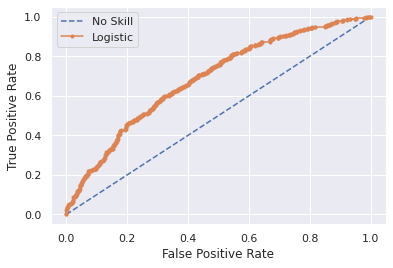

In [ ]:
from sklearn.metrics import roc_curve

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(y_undersample_test.shape[0])]
# predict probabilities
model_lr = LogisticRegression().set_params(**lr_params_undersample).fit(X_undersample_train, y_undersample_train)
lr_probs = model_lr.predict_proba(X_undersample_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_undersample_test, ns_probs)
lr_auc = roc_auc_score(y_undersample_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_undersample_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_undersample_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
test_rf = ModelPreparation(X_train, y_train)
test_rf.define_model(RandomForestClassifier)
rf_params = test_rf.hyperparameters_tuning()
auc_rf, f05_rf = test_rf.apply_best_params(rf_params, X_test, y_test)
print("AUC ROC score on RF:", auc_rf)
print("F0.5 score on RF:", f05_rf)

AUC ROC score on RF: 0.5003398896751546
F0.5 score on RF: 0.008865248226950354


In [ ]:
test_rf_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_rf_undersample.define_model(RandomForestClassifier)
rf_params_undersample = test_rf_undersample.hyperparameters_tuning()
auc_rf_undersample, f05_rf_undersample = test_rf_undersample.apply_best_params(rf_params_undersample, 
                                                                               X_undersample_test, 
                                                                               y_undersample_test)
print("AUC ROC score on RF with undersampling: {:.4f}".format(auc_rf_undersample))
print("F0.5 score on RF with undersampling: {:.4f}".format(f05_rf_undersample))

AUC ROC score on RF with undersampling: 0.6202
F0.5 score on RF with undersampling: 0.5988


In [ ]:
auc_rf_undersample_train, f05_rf_undersample_train = test_rf_undersample.apply_best_params(rf_params_undersample, 
                                                                               X_undersample_train, 
                                                                               y_undersample_train)
print("AUC ROC score on RF with undersampling: {:.4f}".format(auc_rf_undersample_train))
print("F0.5 score on RF with undersampling: {:.4f}".format(f05_rf_undersample_train))

AUC ROC score on RF with undersampling: 0.7884
F0.5 score on RF with undersampling: 0.7809


In [ ]:
model = RandomForestClassifier().set_params(**rf_params).fit(X_undersample_train, y_undersample_train)
y_pred = model.predict(X_undersample_test)
print(classification_report(y_pred, y_undersample_test))

              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61       508
         1.0       0.67      0.58      0.63       616

    accuracy                           0.62      1124
   macro avg       0.62      0.62      0.62      1124
weighted avg       0.63      0.62      0.62      1124



In [ ]:
test = ModelPreparation(X_train, y_train)
test.define_model(RandomForestClassifier)
rf_params = test.hyperparameters_tuning()
model = RandomForestClassifier().set_params(**rf_params).fit(X_undersample_train, y_undersample_train)
y_pred = model.predict(X_undersample_test)
print(classification_report(y_pred, y_undersample_test))

              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61       510
         1.0       0.67      0.58      0.62       614

    accuracy                           0.62      1124
   macro avg       0.62      0.62      0.62      1124
weighted avg       0.62      0.62      0.62      1124



In [ ]:
test_catboost_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_catboost_undersample.define_model(CatBoostClassifier)
catboost_params_undersample = test_catboost_undersample.hyperparameters_tuning()
auc_catboost_undersample, f05_catboost_undersample = test_catboost_undersample.apply_best_params(catboost_params_undersample, 
                                                                               X_undersample_test, 
                                                                               y_undersample_test)
print(catboost_params_undersample.items())
print("AUC ROC score on RF with undersampling: {:.4f}".format(auc_catboost_undersample))
print("F0.5 score on RF with undersampling: {:.4f}".format(f05_catboost_undersample))

Выходные данные были обрезаны до нескольких последних строк (5000).
3:	learn: 0.5508676	total: 147ms	remaining: 7.19s
4:	learn: 0.5257126	total: 177ms	remaining: 6.9s
5:	learn: 0.5116343	total: 208ms	remaining: 6.71s
6:	learn: 0.4944823	total: 244ms	remaining: 6.72s
7:	learn: 0.4861112	total: 274ms	remaining: 6.58s
8:	learn: 0.4679803	total: 320ms	remaining: 6.78s
9:	learn: 0.4609410	total: 352ms	remaining: 6.68s
10:	learn: 0.4377287	total: 383ms	remaining: 6.59s
11:	learn: 0.4255470	total: 415ms	remaining: 6.51s
12:	learn: 0.4102838	total: 447ms	remaining: 6.43s
13:	learn: 0.3935510	total: 479ms	remaining: 6.37s
14:	learn: 0.3752031	total: 511ms	remaining: 6.3s
15:	learn: 0.3561903	total: 557ms	remaining: 6.4s
16:	learn: 0.3435778	total: 589ms	remaining: 6.33s
17:	learn: 0.3283198	total: 619ms	remaining: 6.26s
18:	learn: 0.3124947	total: 649ms	remaining: 6.18s
19:	learn: 0.3025465	total: 680ms	remaining: 6.12s
20:	learn: 0.2885767	total: 710ms	remaining: 6.05s
21:	learn: 0.2837101	tot

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      2620
         1.0       0.56      0.08      0.14       548

    accuracy                           0.83      3168
   macro avg       0.70      0.53      0.52      3168
weighted avg       0.79      0.83      0.77      3168



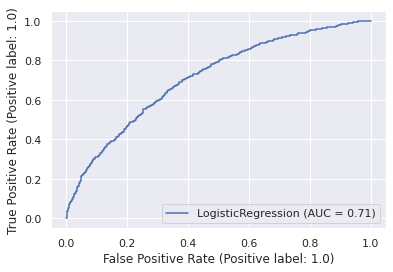

In [ ]:
logres = LogisticRegression()

logres.fit(X_train, y_train)
y_pred1 = logres.predict(X_test)
#print("Accuracy on LogisticRegression=", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))
plot_roc_curve(logres, X_test, y_test)

Accuracy on LogisticRegression with undersampling= 0.6628113879003559
              precision    recall  f1-score   support

         0.0       0.70      0.63      0.66       592
         1.0       0.63      0.70      0.66       532

    accuracy                           0.66      1124
   macro avg       0.66      0.66      0.66      1124
weighted avg       0.67      0.66      0.66      1124



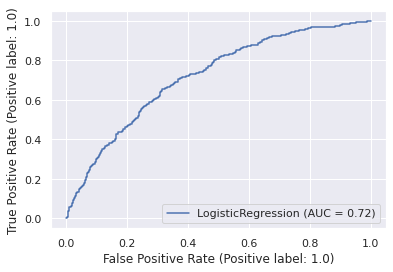

In [ ]:
logres = LogisticRegression()

logres.fit(X_undersample_train, y_undersample_train)
y_pred = logres.predict(X_undersample_test)
print("Accuracy on LogisticRegression with undersampling=", accuracy_score(y_undersample_test, y_pred))
print(classification_report(y_undersample_test, y_pred))
plot_roc_curve(logres, X_undersample_test, y_undersample_test)

Accuracy on AdaBoost Classifier= 0.8295454545454546


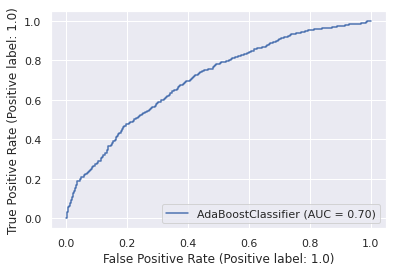

In [ ]:
AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=66)
AdaBoost.fit(X_train, y_train)
y_pred2 = AdaBoost.predict(X_test)

print("Accuracy on AdaBoost Classifier=", accuracy_score(y_test, y_pred2))
plot_roc_curve(AdaBoost, X_test, y_test)

Accuracy with Gradient Boosting : 0.8298611111111112


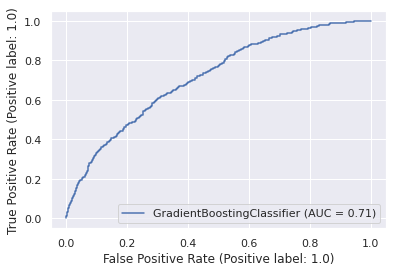

In [ ]:
GradBoost = GradientBoostingClassifier(n_estimators=100, random_state=66)
GradBoost.fit(X_train, y_train)
y_pred3 = GradBoost.predict(X_test)
print("Accuracy with Gradient Boosting :", accuracy_score(y_test, y_pred3))
plot_roc_curve(GradBoost, X_test, y_test)

Accuracy on LGBM Classifier= 0.827020202020202


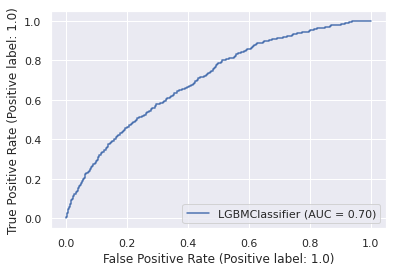

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred4 = lgbm.predict(X_test)
print("Accuracy on LGBM Classifier=", accuracy_score(y_test, y_pred4))
plot_roc_curve(lgbm, X_test, y_test)

LGBM_GetLastError().decode('utf-8') - попробуй декодировать по всем столбцам и выявить плохой - и переименовать - почему то не работает

Accuracy on CatBoost Classifier= 0.8279671717171717
AUC ROC on CatBoost Classifier:


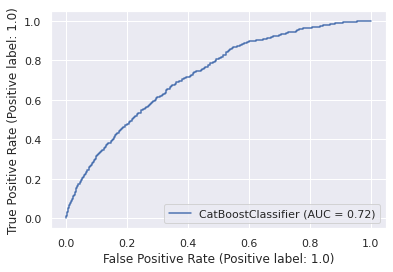

In [ ]:
catBoost = CatBoostClassifier()
catBoost.fit(X_train,y_train,verbose=False)#, plot=True)
y_pred5 = catBoost.predict(X_test)
print("Accuracy on CatBoost Classifier=", accuracy_score(y_test, y_pred5))
print("AUC ROC on CatBoost Classifier:") 
plot_roc_curve(catBoost, X_test, y_test)
#catBoost.score(X_test, y_test)
# тут походу можно просто запихать df изначальный и все скушает

In [ ]:
"""
# небольшой эксперимент с catboost'ом : попробую запихать туда необработанный датасет
model_params = {
    'iterations': 500, 
    'loss_function': 'Logloss', 
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 66,
}

cat_clf = CatBoostClassifier(**model_params)

X_ = df1.drop("Isdefault", axis=1)
y_ = df1["Isdefault"]
y_ = y.iloc[:-2].astype(int)
X_ = X.iloc[:-2, :]

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, train_size=0.8, random_state=66)
cat_clf.fit(X_train_, y_train_)
y_pred_ = cat_clf.predict(X_test_)
print("Accuracy score on raw data with CatBoost Classifier:", accuracy_score(y_test_, y_pred_))
print("Как видно, точность всё таки ниже, чем на обработанных данных => мы сделали предобработку данных неплохо")
"""

NameError: ignored

Accuracy on XGBoost Classifier = 0.8273358585858586
ROC AUC on XGBoost Classifier =


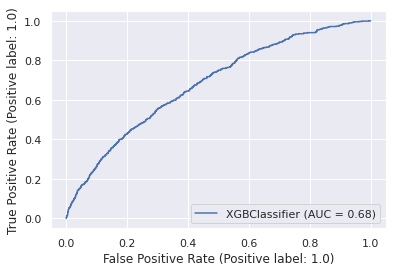

In [ ]:
xg_cl = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_cl.fit(X_train,y_train)

y_pred6 = xg_cl.predict(X_test)
print("Accuracy on XGBoost Classifier =", accuracy_score(y_test, y_pred6))
print("ROC AUC on XGBoost Classifier =")
plot_roc_curve(xg_cl, X_test, y_test)

Accuracy on RandomForest Classifier = 0.8276515151515151
AUC ROC on RandomForest Classifier =


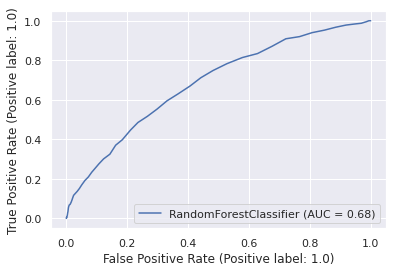

In [ ]:
rf_cl = RandomForestClassifier()
rf_cl.fit(X_train,y_train)

y_pred7 = rf_cl.predict(X_test)
print("Accuracy on RandomForest Classifier =", accuracy_score(y_test, y_pred7))
print("AUC ROC on RandomForest Classifier =")
plot_roc_curve(rf_cl, X_test, y_test)

# Абстрагирование от данного датасета

In [ ]:
data = pd.read_csv('UCI_Credit_Card.csv')
data.head()

In [ ]:
data.drop(columns=['ID'], inplace=True)

In [ ]:
data.head()

In [ ]:
# хреновый датасет, оч мало признаков

In [ ]:
df = pd.read_csv("train_v2.csv")
df.head()